In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import ResNet50_Weights

import matplotlib.pyplot as plt
import os
from tqdm import tqdm

cuda
Train: 104999, Test: 29999, Validation: 15001


Epoch 1/3: 100%|██████████| 3282/3282 [1:12:35<00:00,  1.33s/it, acc=0.986, loss=0.00641] 


Epoch 1/3 | Train Acc: 0.9865 | Val Acc: 0.9961 | Loss: 0.0465 | Val Loss: 0.0112


Epoch 2/3: 100%|██████████| 3282/3282 [58:56<00:00,  1.08s/it, acc=0.997, loss=0.0305]  


Epoch 2/3 | Train Acc: 0.9969 | Val Acc: 0.9989 | Loss: 0.0098 | Val Loss: 0.0032


Epoch 3/3: 100%|██████████| 3282/3282 [1:49:00<00:00,  1.99s/it, acc=0.998, loss=0.0269]    


Epoch 3/3 | Train Acc: 0.9982 | Val Acc: 0.9976 | Loss: 0.0060 | Val Loss: 0.0080
Test Accuracy: 0.9984


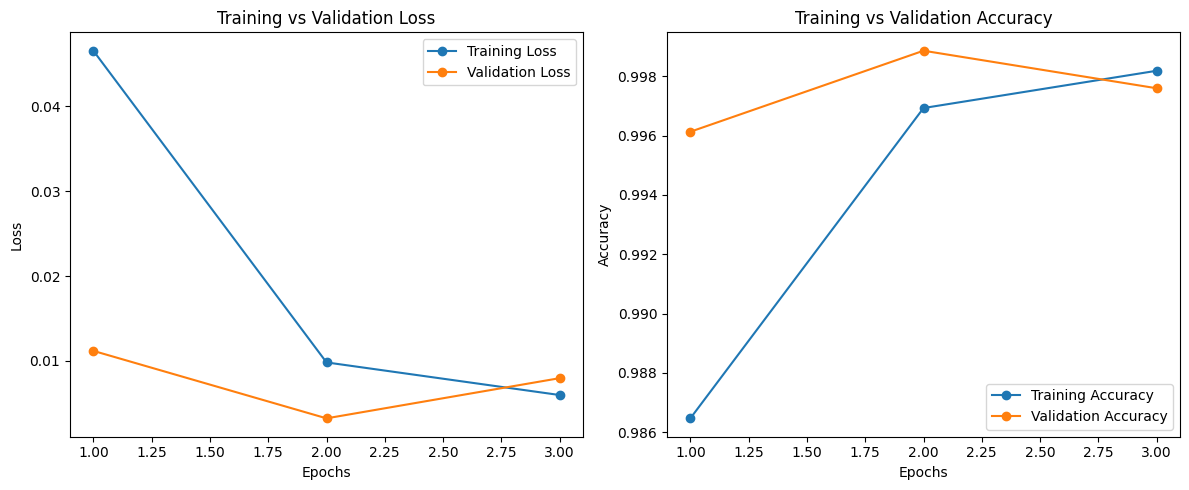

In [3]:
# ✅ Set Paths
DATASET_PATH = r"./data/leaf_coffe_augmented"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
# ✅ Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ Load Dataset
dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)

# ✅ Split Dataset: 70% Train, 20% Test, 10% Validation
train_size = int(0.7 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_ds, test_ds, val_ds = random_split(dataset, [train_size, test_size, val_size])

# ✅ Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_ds)}, Test: {len(test_ds)}, Validation: {len(val_ds)}")

# ✅ Load Pretrained ResNet50
model = models.resnet50(weights= ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(dataset.classes))  # Adjust output layer

model = model.to(DEVICE)

# ✅ Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Lists to store metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# ✅ Training Loop
def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)  # Show live metrics
        
        train_loss = total_loss/len(train_loader)
        train_acc = correct/total
        
        val_acc, val_loss = evaluate(model, val_loader)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# ✅ Evaluation Function
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total, total_loss/len(loader)

# ✅ Start Training
train(model, train_loader, val_loader, EPOCHS)

# ✅ Evaluate on Test Data
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracies 
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label="Training Accuracy", marker="o")
plt.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "trained_model.pth")
print("✅ Model weights saved successfully!")
